In [24]:
# %matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os

os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
# from analysis_pkg.models import *
from analysis_pkg.adptive_lasso import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
ScoreModel = 'AdaptiveLassoScore'  # 'MLPAttentionScore'  #'LogisticRegression' #'MLPScore'
flag_interaction = True  # 是否使用交互项
poly_degree = 2  # 多项式的最高次数
threshold_zero = 1e-4  # 判定系数为零的阈值
sufix = f"{'interaction' if flag_interaction else 'no_interaction'}_{poly_degree}degree_{threshold_zero}"
score_col_name = f"adplasso{'_interaction' if flag_interaction else ''}_{poly_degree}degree_thres{threshold_zero}"
torch.manual_seed(2025)

In [15]:
# ==== 2) load data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [16]:
# ==== 3) preprocess data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [ ]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

model = LinearInteractionModel(
    in_dim=d,
    include_interaction=flag_interaction,   # 是否加入交互项
    poly_degree=poly_degree,       # 多项式的最高次数
)

# 2) 训练：两阶段 Adaptive Lasso + 自动选 λ（不改你原来的训练/打分代码）
model, info = train_pairwise_adalasso(
    model,
    train_loader=dl_tr,
    valid_loader=dl_va,
    lr=2e-3,
    weight_decay=0.0,
    warmup_epochs=5,
    finetune_epochs=20,
    patience=3,
    gamma=1.0,
    eps=1e-4,
    # lambda_grid=[1e-1],          # large penalty grid set
    lambda_grid=[1e-3, 3e-3, 1e-2, 3e-2, 1e-1],          # large penalty grid set
    # lambda_grid=None,  # 自动选 λ 
    lambda_scale=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# 3) （可选）温度标定 & 排序/概率
T = calibrate_temperature(model, dl_va)


== Warmup without L1 ==
[Epoch 01] train_loss=0.6295  val_loss=0.5660
[Epoch 02] train_loss=0.5067  val_loss=0.4934
[Epoch 03] train_loss=0.4536  val_loss=0.4554
[Epoch 04] train_loss=0.4230  val_loss=0.4319
[Epoch 05] train_loss=0.4040  val_loss=0.4164
== Try lambda=1.00e-01 ==
   [λ=1.00e-01 ep=01] train=1.4725  val=0.5118  *
   [λ=1.00e-01 ep=02] train=0.7826  val=0.5467
   [λ=1.00e-01 ep=03] train=0.7640  val=0.5591
   [λ=1.00e-01 ep=04] train=0.7626  val=0.5633
== Best lambda: 0.1  val=0.563324


1. Best lambda: 3e-05  val=0.388488
   1. flag_interaction = True  # 是否使用交互项
   2. poly_degree = 2  # 多项式的最高次数
   3. threshold_zero = 1e-4  # 判定系数为零的阈值
2. Best lambda: 0.0001  val=0.388574
   1. flag_interaction = False  # 是否使用交互项
   2. poly_degree = 2  # 多项式的最高次数
   3. threshold_zero = 1e-4  # 判定系数为零的阈值
3. Best lambda: 0.0003  val=0.451188
   1. flag_interaction = True  # 是否使用交互项
   2. poly_degree = 1  # 多项式的最高次数
   3. threshold_zero = 1e-4  # 判定系数为零的阈值
4. MLP loss: val_loss=0.3993
5. MLP attention: val_loss=0.3788
6. LR: val_loss=0.4551
<!-- 7. XGBoost: 0.03949 -->

In [40]:
# # ==== score all profiles and save ====
# scored_df = pd.read_csv("../data/scored_profiles_shuffled.csv")
# real_scored_df = pd.read_csv("../data/scored_real_profiles.csv")
# X_all = preprocess_test(scored_df.iloc[:,:10])
# all_scores, all_probs = score_profiles(model, X_all, T=T)
# scored_df[score_col_name] = all_scores

# X_real = preprocess_test(real_scored_df.iloc[:,:10])
# real_scores, real_probs = score_profiles(model, X_real, T=T)
# real_scored_df[score_col_name] = real_scores
# scored_df.to_csv(f"../data/scored_profiles_shuffled.csv", index=False)
# real_scored_df.to_csv(f"../data/scored_real_profiles.csv", index=False)

In [41]:
# threshold_zero = 5e-2  # 判定系数为零的阈值
sparse_terms = list_nonzero_terms(model, threshold=threshold_zero)
print("threshold for zero:", threshold_zero)
for key, value in sparse_terms.items():
    print(f"{key}: {len(value)}")

threshold for zero: 0.0001
main: 8
interactions: 30
poly: 8


In [38]:
sparse_terms['poly']

[((0, 0), 0.00010202873090747744),
 ((2, 2), -0.016810785979032516),
 ((3, 3), 0.00020109133038204163),
 ((4, 4), -0.0011412661988288164),
 ((5, 5), 0.0001967248972505331),
 ((6, 6), -1.0737154483795166),
 ((7, 7), 0.00022587919374927878),
 ((8, 8), -0.13313758373260498)]

In [ ]:
df_lasso = pd.DataFrame(columns=range(d),index=range(d))
for (i, v) in sparse_terms['main']:
    v = round(v, 4)
    df_lasso.loc[i, i] = v
for ((i, j), v) in sparse_terms['interactions']:
    v = round(v, 4)
    if i == j:
        df_lasso.loc[i, j] = str(df_lasso.loc[i, j]) + ' | ' + str(v)
    else:
        df_lasso.loc[i, j] = v
        df_lasso.loc[j, i] = v
df_lasso.columns = profiles.columns
df_lasso.index = profiles.columns
df_lasso.to_csv(f"../data/adp_lasso_{sufix}.csv")
df_lasso

In [16]:
# # ==== 5) visualization for training set ====
# pca_train, probs_train, scores_train = visualize_probability_distribution(model, X, T, fig_name=f"3d_plot_0_PCA_{ScoreModel}_{sufix}.png")
# feature_names = profiles.columns.tolist()
# visualize_pca_features(pca_train, X, feature_names)

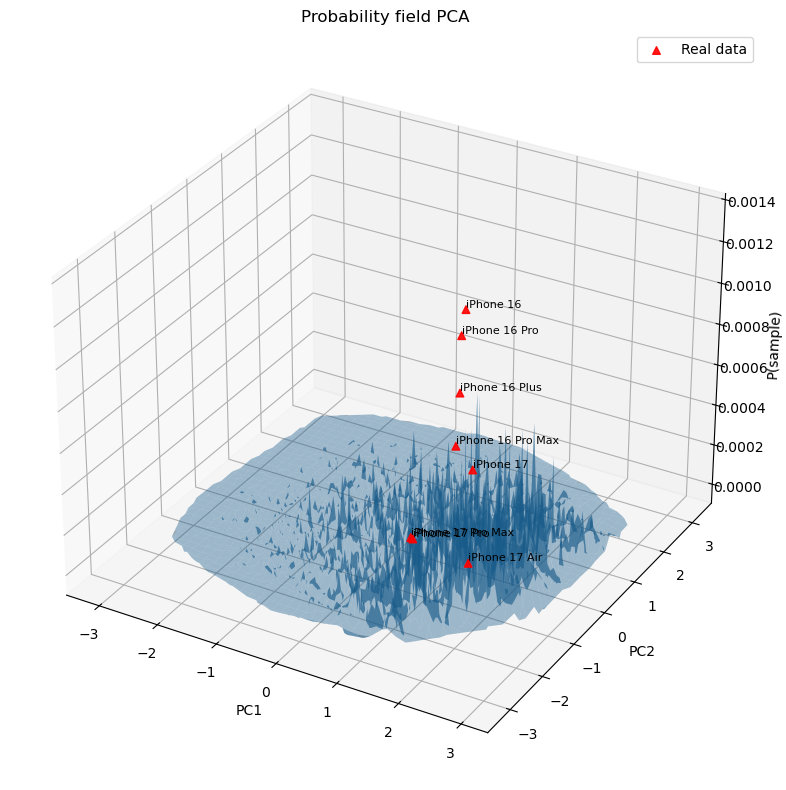

In [17]:
# ==== 6) test on real profiles ====
df_real = pd.read_csv("../data/real_profiles.csv")
X_test = df_real[profiles.columns]
X_test = preprocess_test(X_test)
test_idx = df_real["real model"].tolist()
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([X, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_8_PCA_{ScoreModel}_{sufix}.png",
)

In [18]:
# print the most likely profile
print(profiles.iloc[scores.argmax()])
print('score: ',scores.max())
print("\n====real profiles====\n")
ranks = scores.argsort()[::-1]
for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
    rank = np.where(ranks==p)[0][0]+1
    print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {100*(len(ranks)-rank)/len(ranks):.2f}%")

battery life (in hours of video playback)        24.0
screen size (in inches)                           6.1
thickness (in mm)                                 7.7
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           3.1
ultrawide camera                             equipped
Geekbench multicore score                      8661.0
RAM                                                 8
price                                           949.0
Name: 12600, dtype: object
score:  1.8260573

====real profiles====

iPhone 16's score: 1.50, rank: 5/20008, percentile: 99.98%
iPhone 16 Plus's score: 1.08, rank: 29/20008, percentile: 99.86%
iPhone 16 Pro's score: 1.36, rank: 11/20008, percentile: 99.95%
iPhone 16 Pro Max's score: 0.62, rank: 134/20008, percentile: 99.33%
iPhone 17's score: 0.57, rank: 152/20008, percentile: 99.24%
iPhone 17 Air's score: -5.24, rank: 15286/20008, percentile: 23.60%
iPhon

In [19]:
model.eval()

LinearInteractionModel(
  (mapper): FeatureMap()
  (scorer): Linear(in_features=85, out_features=1, bias=True)
)

In [20]:
# all_profiles = preprocess(profiles)
# _, probs, scores = visualize_probability_distribution(
#     model, torch.cat([all_profiles, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_ALL_PCA_train{processes}_{ScoreModel}.png"
# )
# # print the most likely profile
# print(profiles.iloc[scores.argmax()])
# print('score: ',scores.max())
# print("\n====real profiles====\n")
# ranks = scores.argsort()[::-1]
# for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
#     rank = np.where(ranks==p)[0][0]+1
#     print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {100*(len(ranks)-rank)/len(ranks):.2f}%")